In [1]:
from common import *
from experiment import *
from data import RawData, DirectRawData, PlottableData
from typing import Union, List
from itertools import chain
from heuristic import *
import numpy as np

# Plotting function

In [2]:
def plot_throughput_accuracy(
    treatment: TreatmentData,
    x_labels: List,
    y_labels: List,
    network_settings: List[NetworkSetting],
    title: str,
    split: bool,
    xlabel: str,
    ylabel: str,
    accuracy_vmin: float=-1.0,
    accuracy_vmax: float=1.0,
    pdf: bool=False,
):
    """
    - treatment: Contains the TCP and PEP treatment for a congestion control algorithm.
    - x_labels: The first axis on which to vary the network settings.
    - y_labels: The second axis on which to vary the network settings.
    - network_settings: A len(y_labels) x len(x_labels) array of network settings generated from the x_labels and y_labels.
    - title: The accuracy metric being assessed, the title of the plot.
    - split: If True, evaluates split accuracy. Otherwise end-to-end accuracy.
    """
    
    # Generate data for the three heatmaps from the network settings
    def init_data():
        return [[0 for _ in range(len(x_labels))] for _ in range(len(y_labels))]
    data_real = init_data()
    data_pred = init_data()
    data_accuracy = init_data()
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            ns = network_settings[i][j]
            bottleneck_bw = min(ns.get('bw1'), ns.get('bw2'))
            s1 = NetworkModel(delay=ns.get('delay1'), bw=ns.get('bw1'), loss=ns.get('loss1'))
            s2 = NetworkModel(delay=ns.get('delay2'), bw=ns.get('bw2'), loss=ns.get('loss2'))
            if split:
                real = treatment.real_split_goodput(ns)
                pred = treatment.pred_split_goodput(s1, s2)
                delay1 = ns.get('delay1')
                bw1 = ns.get('bw1')
                loss1 = ns.get('loss1')
                delay2 = ns.get('delay2')
                bw2 = ns.get('bw2')
                loss2 = ns.get('loss2')
                near_pred = treatment.goodput(s1)
                far_pred = treatment.goodput(s2)
                print(f'({i}, {j}) {delay1}ms {loss1}% {bw1}Mbit/s, {delay2}ms {loss2}% {bw2}Mbit/s real_split={real:.3f} pred_split=min({near_pred:.3f}, {far_pred:.3f})={pred:.3f}')
            else:
                real = treatment.real_e2e_goodput(ns)
                pred = treatment.pred_e2e_goodput(s1, s2)

            # Set the values if they are not None
            if real is not None:
                data_real[i][j] = real / bottleneck_bw
            if pred is not None:
                data_pred[i][j] = pred / bottleneck_bw
            if real is not None and pred is not None:
                accuracy = (pred - real) / real
                data_accuracy[i][j] = accuracy

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    
    # Function to plot a single heatmap
    from matplotlib.colors import TwoSlopeNorm
    def plot_heatmap(ax, data, title, accuracy=False):
        if accuracy:
            im = ax.imshow(data, cmap='RdBu', interpolation='nearest',
                           norm=TwoSlopeNorm(vmin=accuracy_vmin, vcenter=0, vmax=accuracy_vmax))
        else:
            im = ax.imshow(data, cmap='plasma', interpolation='nearest', vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.set_yticks(np.arange(len(y_labels)))
        ax.set_yticklabels(y_labels)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        
        # Add numerical labels to each square
        for i in range(len(y_labels)):
            for j in range(len(x_labels)):
                ax.text(j, i, f"{data[i][j]:.2f}", ha='center', va='center',
                        color='black', fontsize=10)
        
        return im
    
    # Plot each heatmap
    treatment_label = plt_label[treatment.tcp]
    im1 = plot_heatmap(axes[0], data_real, f'{treatment_label} {title} (Measured)')
    im2 = plot_heatmap(axes[1], data_pred, f'{treatment_label} {title} (Predicted)')
    im3 = plot_heatmap(axes[2], data_accuracy, f'{treatment_label} {title} (Accuracy)', accuracy=True)
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0], orientation='vertical', shrink=0.65, label='Link Rate Utilization')
    fig.colorbar(im2, ax=axes[1], orientation='vertical', shrink=0.65, label='Link Rate Utilization')
    fig.colorbar(im3, ax=axes[2], orientation='vertical', shrink=0.65, label='Accuracy')
    
    # Show the plot
    if pdf:
        split_str = 'split' if split else 'e2e'
        has_loss = 'With Loss' in title
        loss_str = 'with_loss' if has_loss else 'without_loss'
        save_pdf(f'output/accuracy_{split_str}_{loss_str}.pdf')
    plt.show()

# Data generation functions

In [3]:
def _tuple_list_to_ordered_set(tuple_list):
    arr = list(chain.from_iterable(tuple_list))
    arr = list(set(arr))
    arr.sort()
    return arr

def gen_direct_data_from_splits(treatments, bw_splits, delay_splits, loss_splits, timeout=180, num_trials=1):
    plottable_data = gen_direct_data(
        losses=_tuple_list_to_ordered_set(loss_splits),
        delays=_tuple_list_to_ordered_set(delay_splits),
        bws=_tuple_list_to_ordered_set(bw_splits),
        treatments=treatments,
        num_trials=num_trials,
        timeout=timeout,
    )
    return plottable_data

def gen_data(treatments, network_settings, timeout=None, execute=False, num_trials=1):
    network_settings = list(chain.from_iterable(network_settings))
    data_sizes = [get_data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]
    exp = Experiment(
        num_trials, treatments, network_settings, data_sizes,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = RawData(exp, execute=execute)
    plottable_data = PlottableData(raw_data, metric='throughput_mbps')
    return plottable_data

In [4]:
def gen_network_settings_without_loss(bw_splits, delay_splits):
    network_settings = []
    for bw1, bw2 in bw_splits:
        nses = []
        for delay1, delay2 in delay_splits:
            ns = NetworkSetting(delay1=delay1, delay2=delay2, bw1=bw1, bw2=bw2, loss1=0, loss2=0)
            nses.append(ns)
        network_settings.append(nses)
    return network_settings

In [5]:
def gen_x_labels_with_loss(bw_splits, delay_splits):
    labels = []
    for delay1, delay2 in delay_splits:
        for bw1, bw2 in bw_splits:
            label = f'({bw1}, {bw2}), ({delay1}, {delay2})'
            labels.append(label)
    return labels

def gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits):
    network_settings = []
    for loss1, loss2 in loss_splits:
        nses = []
        for delay1, delay2 in delay_splits:
            for bw1, bw2 in bw_splits:
                ns = NetworkSetting(delay1=delay1, delay2=delay2, bw1=bw1, bw2=bw2, loss1=loss1, loss2=loss2)
                nses.append(ns)
        network_settings.append(nses)
    return network_settings

# Throughput accuracy

## Without loss

In [6]:
def plot_throughput_accuracy_without_loss(tcp_treatment, pep_treatment, pdf=False,
                                          e2e=False, split=False, execute=False, num_trials=10):
    # Define parameters
    delay_splits = [(1, 80), (20, 60), (40, 40), (60, 20), (80, 1)]
    bw_splits = [(10, 50), (10, 30), (10, 10), (30, 10), (50, 10)]
    network_settings = gen_network_settings_without_loss(bw_splits, delay_splits)
    
    # Generate data
    data = gen_data([tcp_treatment, pep_treatment], network_settings, timeout=180,
                    execute=execute, num_trials=num_trials)
    direct_data = gen_direct_data_from_splits([tcp_treatment], bw_splits=bw_splits, delay_splits=delay_splits,
                                  loss_splits=[(0, 0)], timeout=None, num_trials=num_trials)
    treatment = TreatmentData(tcp_treatment, pep_treatment=pep_treatment, onehop_data=data, direct_data=direct_data)
    
    # Plot heatmaps
    xlabel = 'Delay Split (ms)'
    ylabel = 'Bandwidth Split (Mbit/s)'
    if e2e:
        plot_throughput_accuracy(treatment, x_labels=delay_splits, y_labels=bw_splits,
                                 network_settings=network_settings, xlabel=xlabel, ylabel=ylabel,
                                 title='End-to-End Throughput,\nWithout Loss', split=False, pdf=pdf)
    if split:
        plot_throughput_accuracy(treatment, x_labels=delay_splits, y_labels=bw_splits,
                                 network_settings=network_settings, xlabel=xlabel, ylabel=ylabel,
                                 title='Split Throughput,\nWithout Loss', split=True, pdf=pdf)

(0, 0) 1ms 0% 10Mbit/s, 80ms 0% 50Mbit/s real_split=8.635 pred_split=min(9.520, 41.076)=9.520
(0, 1) 20ms 0% 10Mbit/s, 60ms 0% 50Mbit/s real_split=8.609 pred_split=min(9.246, 42.305)=9.246
(0, 2) 40ms 0% 10Mbit/s, 40ms 0% 50Mbit/s real_split=8.718 pred_split=min(9.036, 43.756)=9.036
(0, 3) 60ms 0% 10Mbit/s, 20ms 0% 50Mbit/s real_split=8.678 pred_split=min(8.797, 45.715)=8.797
(0, 4) 80ms 0% 10Mbit/s, 1ms 0% 50Mbit/s real_split=8.585 pred_split=min(8.551, 45.986)=8.551
(1, 0) 1ms 0% 10Mbit/s, 80ms 0% 30Mbit/s real_split=8.635 pred_split=min(9.520, 24.792)=9.520
(1, 1) 20ms 0% 10Mbit/s, 60ms 0% 30Mbit/s real_split=8.611 pred_split=min(9.246, 25.620)=9.246
(1, 2) 40ms 0% 10Mbit/s, 40ms 0% 30Mbit/s real_split=8.726 pred_split=min(9.036, 26.539)=9.036
(1, 3) 60ms 0% 10Mbit/s, 20ms 0% 30Mbit/s real_split=8.673 pred_split=min(8.797, 27.552)=8.797
(1, 4) 80ms 0% 10Mbit/s, 1ms 0% 30Mbit/s real_split=8.514 pred_split=min(8.551, 21.687)=8.551
(2, 0) 1ms 0% 10Mbit/s, 80ms 0% 10Mbit/s real_split=8.

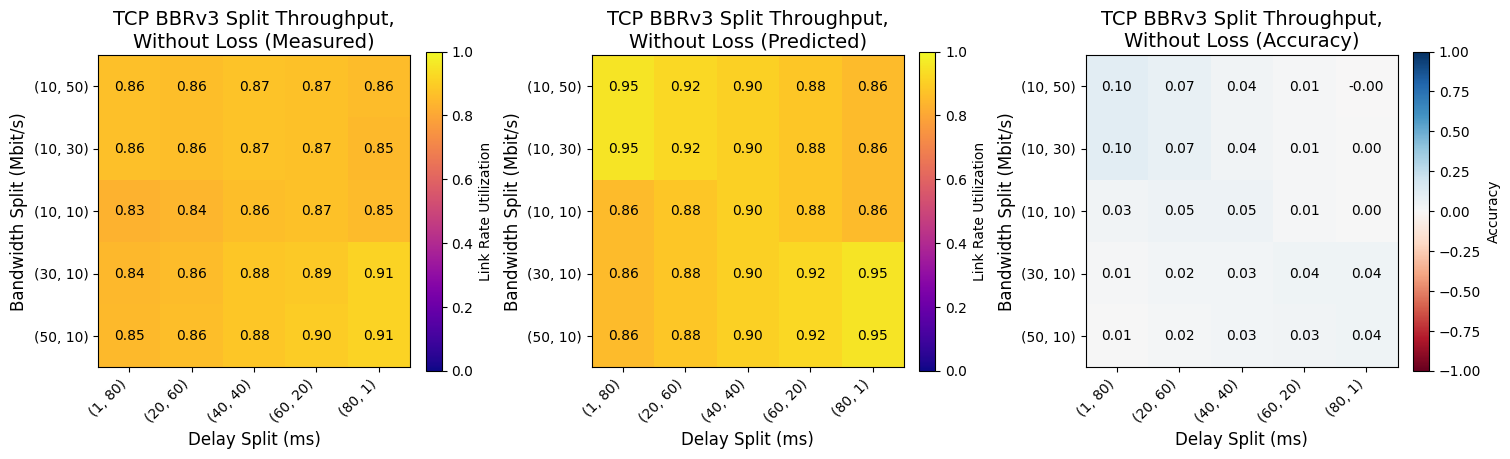

output/accuracy_e2e_without_loss.pdf


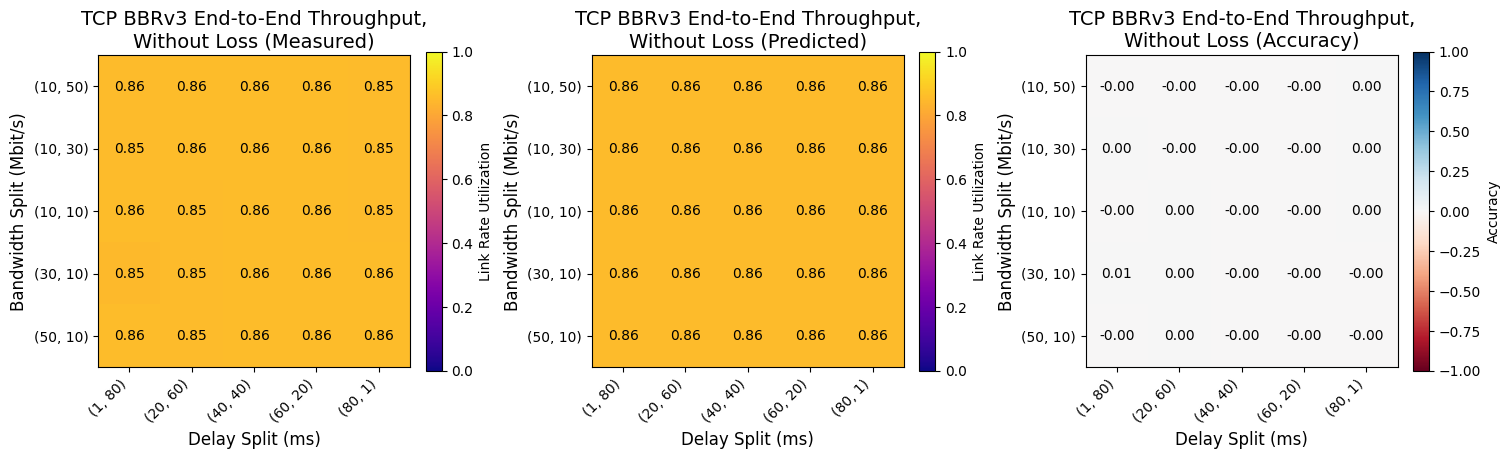

In [7]:
plot_throughput_accuracy_without_loss(TCP_BBRV3, PEP_BBRV3, split=True, num_trials=40, execute=True, pdf=True)
plot_throughput_accuracy_without_loss(TCP_BBRV3, PEP_BBRV3, e2e=True, num_trials=40, execute=True, pdf=True)

## With loss

In [8]:
def plot_throughput_accuracy_with_loss(tcp_treatment, pep_treatment, pdf=False,
                                       e2e=False, split=False, execute=False, num_trials=1):
    # Define parameters
    delay_splits = [(1, 80), (40, 40), (80, 1)]
    bw_splits = [(10, 50), (10, 10), (50, 10)]
    loss_splits = [(4, 0), (3, 1), (2, 2), (1, 3), (0, 4)]
    network_settings = gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits)
    
    # Generate data
    data = gen_data([tcp_treatment, pep_treatment], network_settings, timeout=180, execute=execute, num_trials=num_trials)
    direct_data = gen_direct_data_from_splits([tcp_treatment], bw_splits=bw_splits, delay_splits=delay_splits,
                                              loss_splits=loss_splits, timeout=None, num_trials=num_trials)
    treatment = TreatmentData(tcp_treatment, pep_treatment=pep_treatment, onehop_data=data, direct_data=direct_data)
    
    # Plot heatmaps
    x_labels = gen_x_labels_with_loss(bw_splits, delay_splits)
    xlabel = 'Bandwidth (Mbit/s) and Delay (ms) Split'
    ylabel = 'Loss Split (%)'
    if e2e:
        plot_throughput_accuracy(treatment, x_labels=x_labels, y_labels=loss_splits, network_settings=network_settings,
                                 title='End-to-End Throughput,\nWith Loss', split=False, xlabel=xlabel, ylabel=ylabel, pdf=pdf)
    if split:
        plot_throughput_accuracy(treatment, x_labels=x_labels, y_labels=loss_splits, network_settings=network_settings,
                                 title='Split Throughput,\nWith Loss', split=True, xlabel=xlabel, ylabel=ylabel, pdf=pdf)

MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 2 --topology direct -t 21 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 40 --loss1 4 --topology direct -t 31 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 3 --topology direct -t 31 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 4 --topology direct -t 33 --label tcp_bbr3 tcp -cca bbr -n 62500000
(0, 0) 1ms 4% 10Mbit/s, 80ms 0% 50Mbit/s real_split=8.421 pred_split=min(8.714, 41.076)=8.714
(0, 1) 1ms 4% 10Mbit/s, 80ms 0% 10Mbit/s real_split=8.193 pred_split=min(8.714, 8.551)=8.551
(0, 2) 1ms 4% 50Mbit/s, 80ms 0% 10Mbit/s real_split=8.433 pred_split=min(36.968, 8.551)=8.551
(0, 3) 40ms 4% 10Mbit/s, 40ms 0% 50Mbit/s real_split=5.515 pred_split=min(5.238, 43.756)=5.238
(0, 4) 40ms 4% 10Mbit/s, 40ms 0% 10Mbit/s real_split=5.629 pred_

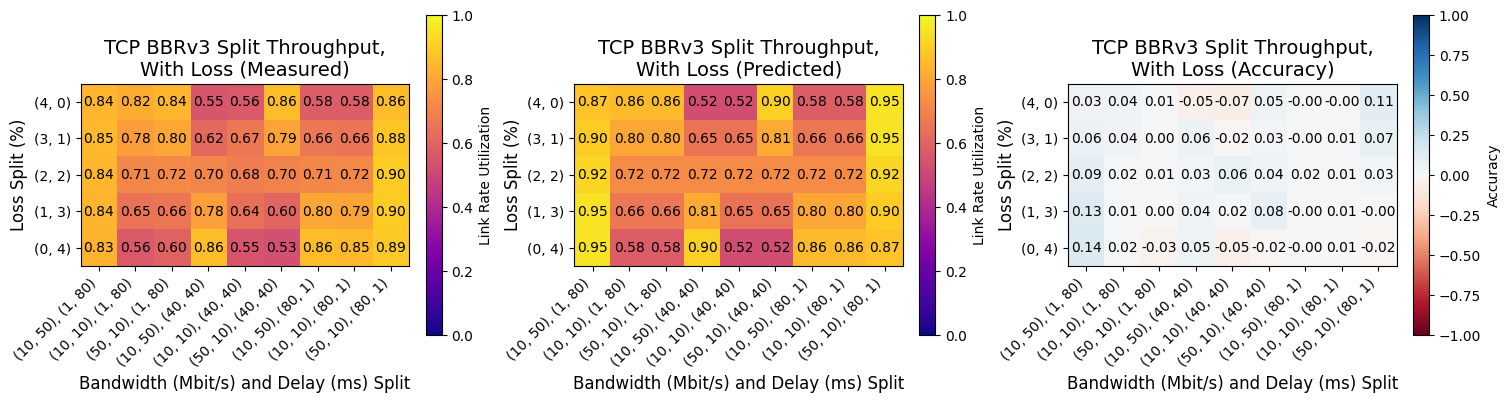

MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 2 --topology direct -t 21 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 40 --loss1 4 --topology direct -t 31 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 3 --topology direct -t 31 --label tcp_bbr3 tcp -cca bbr -n 62500000
MISSING: sudo -E python3 emulation/main.py --bw1 50 --delay1 80 --loss1 4 --topology direct -t 33 --label tcp_bbr3 tcp -cca bbr -n 62500000
output/accuracy_e2e_with_loss.pdf


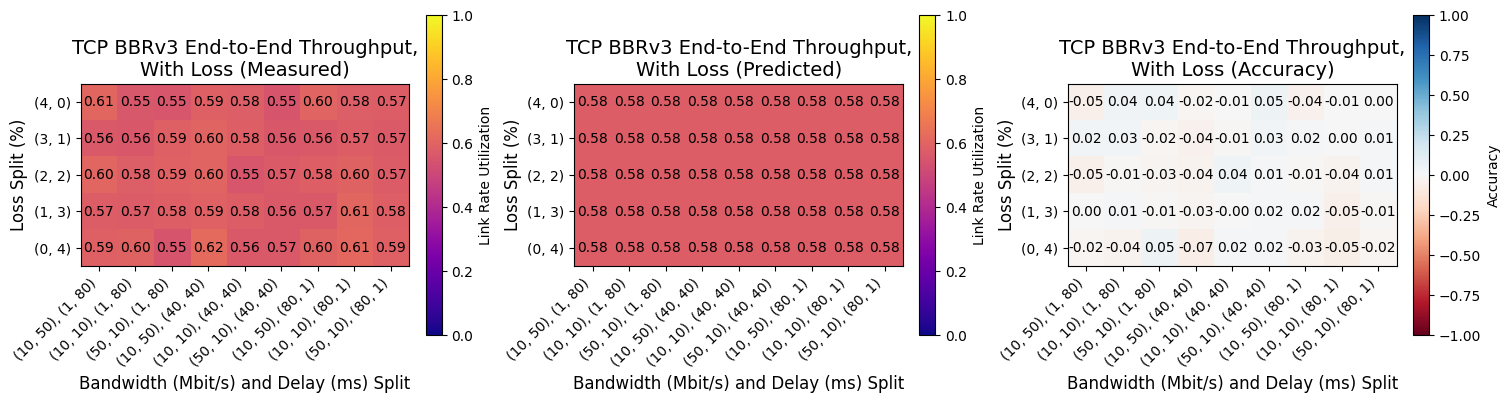

In [9]:
plot_throughput_accuracy_with_loss(TCP_BBRV3, PEP_BBRV3, split=True, num_trials=40, execute=True, pdf=True)
plot_throughput_accuracy_with_loss(TCP_BBRV3, PEP_BBRV3, e2e=True, num_trials=40, execute=True, pdf=True)